In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import TimeSeriesDataset
from models import MLR, MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Generate a synthetic time-series data

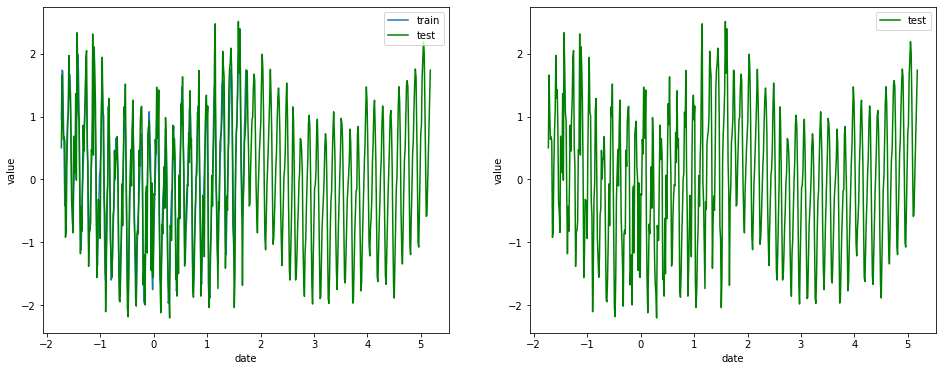

In [2]:
# data = np.loadtxt('data/co2_mm_mlo.txt')
# signal = pd.DataFrame(data[:, [2, 4]], columns=['date', 'average'])

import h5py

with h5py.File("data/co2/co2_train.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1)
    signal_train = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

with h5py.File("data/co2/co2_test.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1) * 0
    signal_test = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

signal_train_noisy = signal_train.copy()
signal_train_noisy.value = signal_train_noisy.value + .5 * np.random.randn(signal_train_noisy.shape[0])
# signal_test = pd.concat([signal_train_noisy, signal_test], axis=0).reset_index(drop=True)

signal_train_shifted = signal_train.copy()
signal_train_shifted.date = signal_train_shifted.date + (signal_train_shifted.date.max() - signal_train_shifted.date.min())
signal_test = pd.concat([signal_train_noisy, signal_train_shifted], axis=0).reset_index(drop=True)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sb.lineplot(ax=ax[0], x='date', y='value', data=signal_train, label='train')
sb.lineplot(ax=ax[0], x='date', y='value', color='g', data=signal_test, label='test')
ax[0].legend()
sb.lineplot(ax=ax[1], x='date', y='value', color='g', data=signal_test, label='test')
ax[1].legend();

In [3]:
# stl = STL(train_labels, period=12, seasonal=7)
# stl_result = stl.fit()
# stl_result.plot()

In [82]:
train_labels = signal_train.value
train_data = np.hstack([signal_train.date.to_numpy().reshape(-1, 1)])
test_labels = signal_test.value
test_data = np.hstack([signal_test.date.to_numpy().reshape(-1, 1)])

In [83]:
train_data.shape, test_data.shape

((272, 1), (544, 1))

((272, 1), (272,))

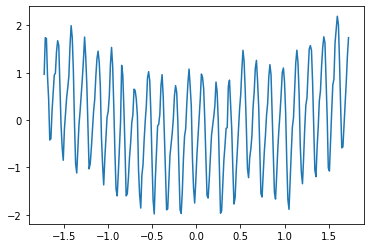

In [84]:
# train_data = train_data[:12*21, :]
# train_labels = np.array(train_labels[:12*21])
test_data = train_data
test_labels = train_labels

train_loader = DataLoader(TimeSeriesDataset(train_data, train_labels), batch_size=136, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(test_data, test_labels), batch_size=136, shuffle=False)
plt.plot(train_data, train_labels)
train_data.shape, train_labels.shape
# type(train_data), type(train_labels)

## [Training Model and Configuration](#Training-Model-and-Configuration)

In [90]:
hidden_layers = [1000, 1000, 1000, 1000]
dropout = 0
lr = 0.001
tau = 1
wd = 0.000005 #  0.01**2 * (1 - dropout) / (2. * len(train_loader) * tau)

model = MLR(input_size=train_data.shape[1], nclasses=1, hidden_layers=hidden_layers, dropout=dropout, batch_norm=True)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
model.net

Sequential(
  (0): Linear(in_features=1, out_features=1000, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1000, out_features=1000, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1000, out_features=1000, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=1000, out_features=1, bias=True)
)

In [ ]:
reset_loss_every = 100
n_epochs = 800
device = "cpu"
model.to(device)
model.train()

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0
    for it, batch in enumerate(train_loader):
#         if it > 0:
            
#             continue
        optimizer.zero_grad()
        data, target = batch
        output = model(data.float().to(device))
        loss = F.mse_loss(output, target.view(-1, 1).to(device))
        num_samples += len(target)
        loss_epoch += loss.item() * len(target)
        loss.backward()
        optimizer.step()
        
    print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")
    
    if (epoch % n_epochs) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

epoch: 0, num_samples: 272, average_loss: 0.12327748537063599
epoch: 1, num_samples: 272, average_loss: 0.07791685685515404
epoch: 2, num_samples: 272, average_loss: 0.11560135707259178
epoch: 3, num_samples: 272, average_loss: 0.07228363677859306
epoch: 4, num_samples: 272, average_loss: 0.06252412125468254
epoch: 5, num_samples: 272, average_loss: 0.063326271250844
epoch: 6, num_samples: 272, average_loss: 0.06715406849980354
epoch: 7, num_samples: 272, average_loss: 0.06537081114947796
epoch: 8, num_samples: 272, average_loss: 0.07177378609776497
epoch: 9, num_samples: 272, average_loss: 0.053799839690327644
epoch: 10, num_samples: 272, average_loss: 0.05053519085049629
epoch: 11, num_samples: 272, average_loss: 0.04976546764373779
epoch: 12, num_samples: 272, average_loss: 0.05265902727842331
epoch: 13, num_samples: 272, average_loss: 0.05720248632133007
epoch: 14, num_samples: 272, average_loss: 0.04718688689172268
epoch: 15, num_samples: 272, average_loss: 0.07335754111409187
epo

epoch: 130, num_samples: 272, average_loss: 0.02922380156815052
epoch: 131, num_samples: 272, average_loss: 0.024658394046127796
epoch: 132, num_samples: 272, average_loss: 0.026739349588751793
epoch: 133, num_samples: 272, average_loss: 0.04817039519548416
epoch: 134, num_samples: 272, average_loss: 0.036870259791612625
epoch: 135, num_samples: 272, average_loss: 0.03252828400582075
epoch: 136, num_samples: 272, average_loss: 0.04981718026101589
epoch: 137, num_samples: 272, average_loss: 0.037753645330667496
epoch: 138, num_samples: 272, average_loss: 0.026276167016476393
epoch: 139, num_samples: 272, average_loss: 0.04291919991374016
epoch: 140, num_samples: 272, average_loss: 0.04733227379620075
epoch: 141, num_samples: 272, average_loss: 0.03227943368256092
epoch: 142, num_samples: 272, average_loss: 0.043876444920897484
epoch: 143, num_samples: 272, average_loss: 0.022042077500373125
epoch: 144, num_samples: 272, average_loss: 0.039699713699519634
epoch: 145, num_samples: 272, av

epoch: 258, num_samples: 272, average_loss: 0.020408574491739273
epoch: 259, num_samples: 272, average_loss: 0.03766897600144148
epoch: 260, num_samples: 272, average_loss: 0.05373542569577694
epoch: 261, num_samples: 272, average_loss: 0.03879007510840893
epoch: 262, num_samples: 272, average_loss: 0.02842742297798395
epoch: 263, num_samples: 272, average_loss: 0.03267217148095369
epoch: 264, num_samples: 272, average_loss: 0.05852522514760494
epoch: 265, num_samples: 272, average_loss: 0.03425222169607878
epoch: 266, num_samples: 272, average_loss: 0.038870783522725105
epoch: 267, num_samples: 272, average_loss: 0.03918207250535488
epoch: 268, num_samples: 272, average_loss: 0.03261219896376133
epoch: 269, num_samples: 272, average_loss: 0.02825162746012211
epoch: 270, num_samples: 272, average_loss: 0.024725002236664295
epoch: 271, num_samples: 272, average_loss: 0.03684431500732899
epoch: 272, num_samples: 272, average_loss: 0.03710734099149704
epoch: 273, num_samples: 272, average

epoch: 386, num_samples: 272, average_loss: 0.04269900359213352
epoch: 387, num_samples: 272, average_loss: 0.0316423662006855
epoch: 388, num_samples: 272, average_loss: 0.07788065634667873
epoch: 389, num_samples: 272, average_loss: 0.03460057359188795
epoch: 390, num_samples: 272, average_loss: 0.029233389534056187
epoch: 391, num_samples: 272, average_loss: 0.03046626877039671
epoch: 392, num_samples: 272, average_loss: 0.06134801544249058
epoch: 393, num_samples: 272, average_loss: 0.0521099716424942
epoch: 394, num_samples: 272, average_loss: 0.03361994493752718
epoch: 395, num_samples: 272, average_loss: 0.04758143611252308
epoch: 396, num_samples: 272, average_loss: 0.04007798247039318
epoch: 397, num_samples: 272, average_loss: 0.04075364023447037
epoch: 398, num_samples: 272, average_loss: 0.026244488544762135
epoch: 399, num_samples: 272, average_loss: 0.03786116559058428
epoch: 400, num_samples: 272, average_loss: 0.03759787604212761
epoch: 401, num_samples: 272, average_lo

epoch: 514, num_samples: 272, average_loss: 0.03284905944019556
epoch: 515, num_samples: 272, average_loss: 0.04154904931783676
epoch: 516, num_samples: 272, average_loss: 0.031737977638840675
epoch: 517, num_samples: 272, average_loss: 0.03917882218956947
epoch: 518, num_samples: 272, average_loss: 0.0332345524802804
epoch: 519, num_samples: 272, average_loss: 0.023563994094729424
epoch: 520, num_samples: 272, average_loss: 0.060170937329530716
epoch: 521, num_samples: 272, average_loss: 0.03215229418128729
epoch: 522, num_samples: 272, average_loss: 0.03699043020606041
epoch: 523, num_samples: 272, average_loss: 0.04698549583554268
epoch: 524, num_samples: 272, average_loss: 0.0536615364253521
epoch: 525, num_samples: 272, average_loss: 0.027853735722601414
epoch: 526, num_samples: 272, average_loss: 0.029458205215632915
epoch: 527, num_samples: 272, average_loss: 0.040323007851839066
epoch: 528, num_samples: 272, average_loss: 0.031797354109585285
epoch: 529, num_samples: 272, avera

In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
model.to(device)

# model.train()
model.eval()

ensemble_size = 10

gt = []
forecast = []
for it, batch in enumerate(test_loader):
    data, target = batch
    output = []
    for ensemble_it in range(ensemble_size):
        output.append(model(data.float().to(device)).data.numpy())
    output = np.hstack(output)
    forecast.append(output)
    gt.append(target.view(-1).data.numpy())
    
forecast = np.vstack(forecast)
predictive_mean = forecast.mean(1)
predictive_std = forecast.std(1)
print(predictive_mean.shape)
# print(predictive_std)
gt = np.hstack(gt)
mse_loss = ((gt - predictive_mean)**2).mean()
print(f"Test mse_loss = {mse_loss}")

fig, axes = plt.subplots(figsize=(16, 6))
axes.plot(train_data.squeeze(), train_labels.squeeze(), 'b', alpha=0.8);
axes.axvline(train_data.squeeze()[-1], color='g',linestyle='--');
axes.plot(test_data.squeeze(), predictive_mean, color='r', label="Forecast")
# axes.fill_between(test_data.squeeze(), predictive_mean-2*predictive_std, predictive_mean+2*predictive_std, label='prediction interval', color='g', alpha=0.9);
axes.legend();

Repeat the above training+evaluation experiment for two different values of DropourRate={0, 0.5} in the [Training-Model-and-Configuration](http://localhost:8888/notebooks/uncertainty_regression.ipynb#Training-Model-and-Configuration) cell (above) and see how that single change introduces the prediction interval.